<a href="https://colab.research.google.com/github/MSIMulti/AIFFEL_quest_cr/blob/master/Exploration/Ex03/exploration_03_MansoonIm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [16]:
!pip install mediapipe

이미지 폴더 경로 확인: /content/sample_data/exploration_03/image
출력 폴더 경로 확인: /content/sample_data/exploration_03/output
처리 중인 이미지: /content/sample_data/exploration_03/image/no_bg_image.png
모델 예측 중: no_bg_image.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


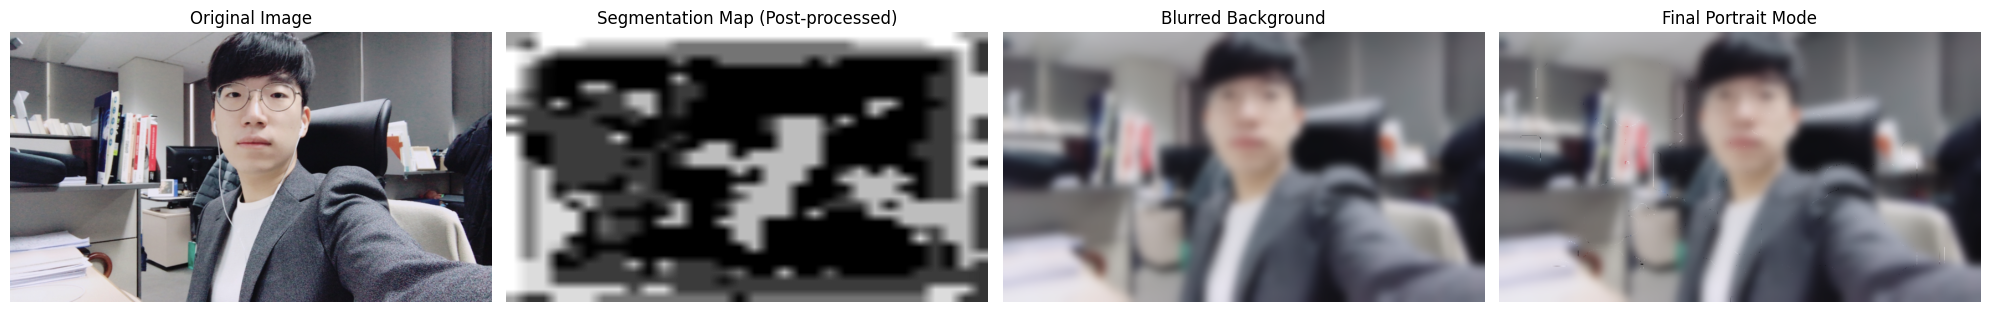

no_bg_image.png 처리가 완료되었습니다. 결과 저장: /content/sample_data/exploration_03/output/portrait_no_bg_image.png
처리 중인 이미지: /content/sample_data/exploration_03/image/20241119_135825.jpg
모델 예측 중: 20241119_135825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


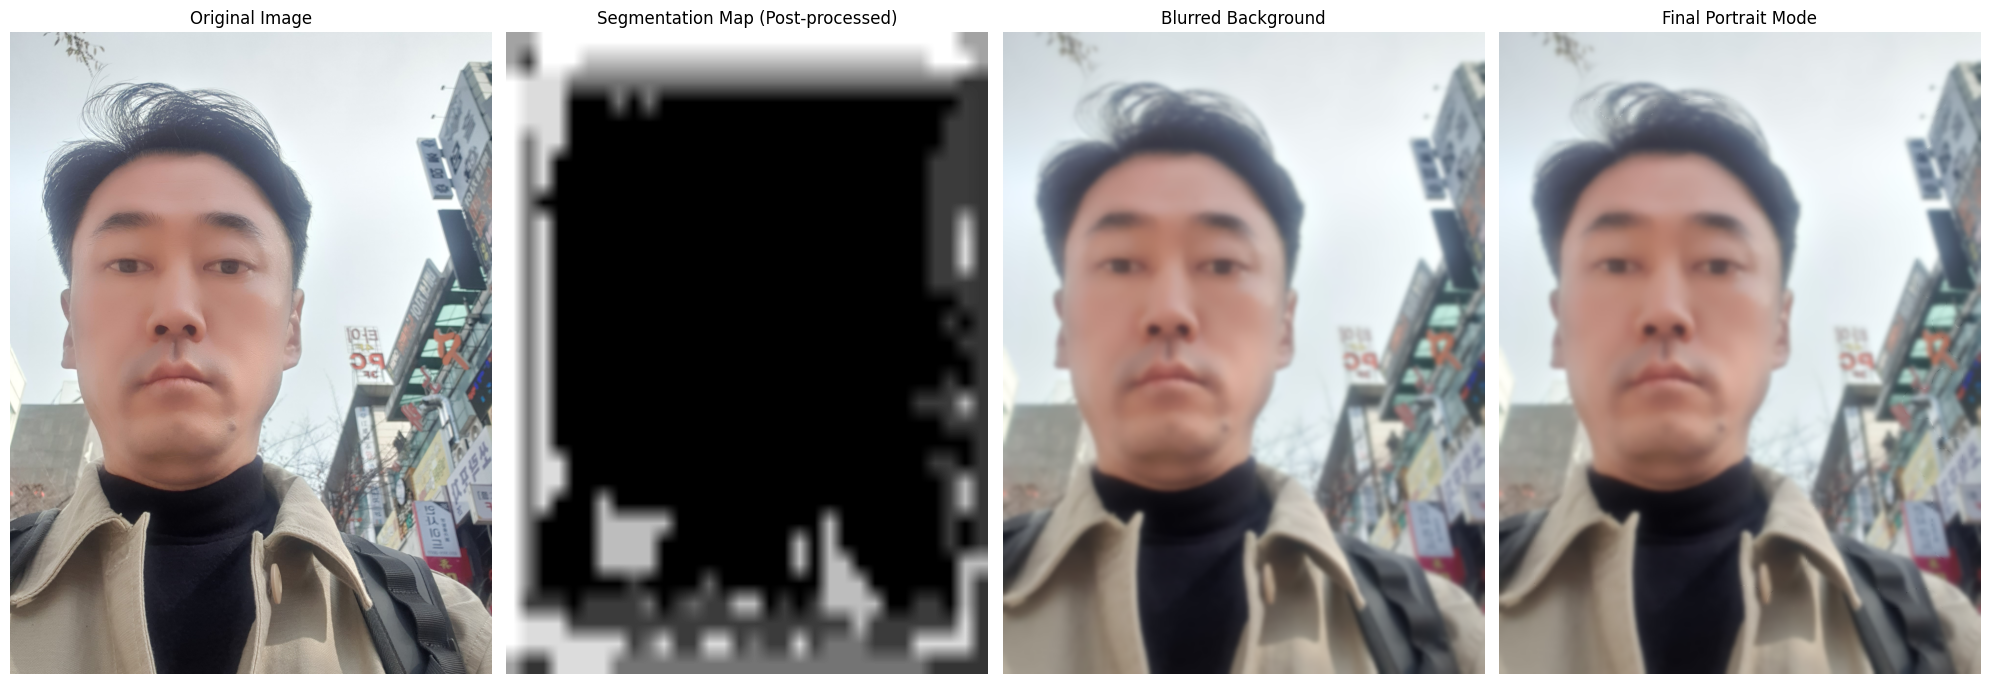

20241119_135825.jpg 처리가 완료되었습니다. 결과 저장: /content/sample_data/exploration_03/output/portrait_20241119_135825.jpg
모든 이미지 처리가 완료되었습니다.


In [24]:
# DeepLabV3+ 모델 로드 (ResNet-101 백본 사용, 입력 크기 변경)
model = tf.keras.applications.ResNet101(
    weights='imagenet', include_top=False, input_shape=(1024, 1024, 3)
)

# 경로 설정
image_folder = '/content/sample_data/exploration_03/image'
output_folder = '/content/sample_data/exploration_03/output'

# 폴더 생성 확인 및 생성
if not os.path.exists(image_folder):
    os.makedirs(image_folder)
    print(f"이미지 폴더를 생성했습니다: {image_folder}")
else:
    print(f"이미지 폴더 경로 확인: {image_folder}")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"출력 폴더를 생성했습니다: {output_folder}")
else:
    print(f"출력 폴더 경로 확인: {output_folder}")

# 이미지 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)
    print(f"처리 중인 이미지: {img_path}")

    # 이미지 읽기
    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # 원본 크기 저장
    original_size = (image.shape[1], image.shape[0])

    # 입력 이미지 전처리
    input_image = cv2.resize(image, (1024, 1024))  # 더 큰 해상도로 변경
    input_image = np.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1

    # 모델 예측
    print(f"모델 예측 중: {image_name}")
    predictions = model.predict(input_image, verbose=1)
    segmentation_map = np.argmax(predictions, axis=-1)[0]

    # 원본 크기로 세그멘테이션 맵 리사이즈
    segmentation_map = cv2.resize(segmentation_map.astype(np.uint8), original_size)

    # 모폴로지 연산 적용 (팽창 후 침식으로 인물 영역 확실히)
    kernel = np.ones((5, 5), np.uint8)
    segmentation_map = cv2.morphologyEx(segmentation_map, cv2.MORPH_CLOSE, kernel)

    # 배경 흐림 처리
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 마스크 생성 및 적용
    condition = segmentation_map == 15  # 클래스 15가 인물을 나타낸다고 가정
    mask = np.stack([condition] * 3, axis=-1)
    output_image = np.where(mask, image, blurred_bg)

    # 시각적 비교
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(segmentation_map, cmap='gray')
    axes[1].set_title("Segmentation Map (Post-processed)")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(blurred_bg, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Blurred Background")
    axes[2].axis('off')

    axes[3].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[3].set_title("Final Portrait Mode")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 저장
    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    success = cv2.imwrite(output_path, output_image)
    if success:
        print(f"{image_name} 처리가 완료되었습니다. 결과 저장: {output_path}")
    else:
        print(f"이미지 저장 실패: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")

no_bg_image.png 처리 완료. 저장: /content/sample_data/exploration_03/output/portrait_no_bg_image.png


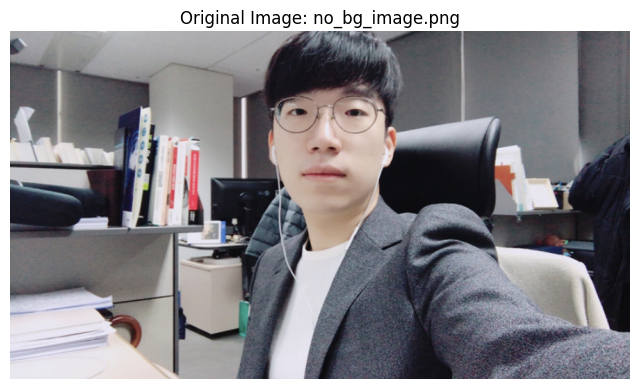

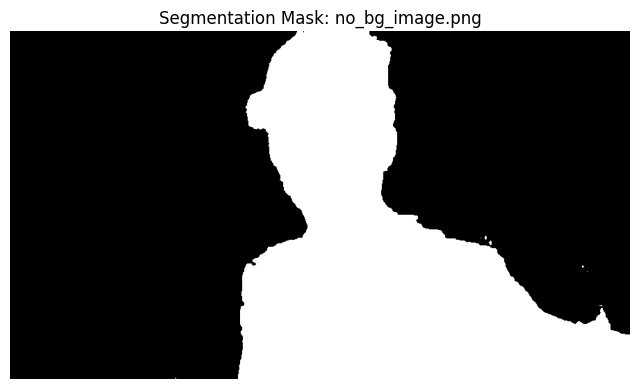

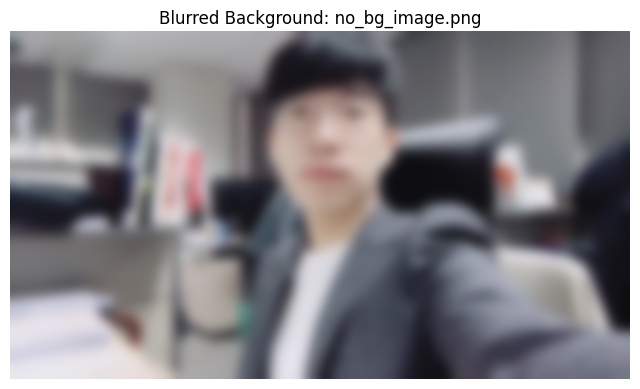

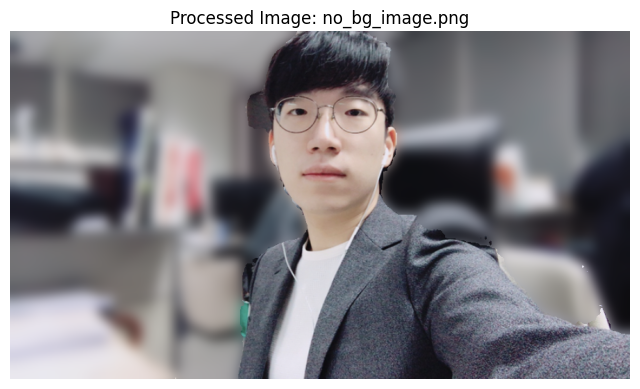

20241119_135825.jpg 처리 완료. 저장: /content/sample_data/exploration_03/output/portrait_20241119_135825.jpg


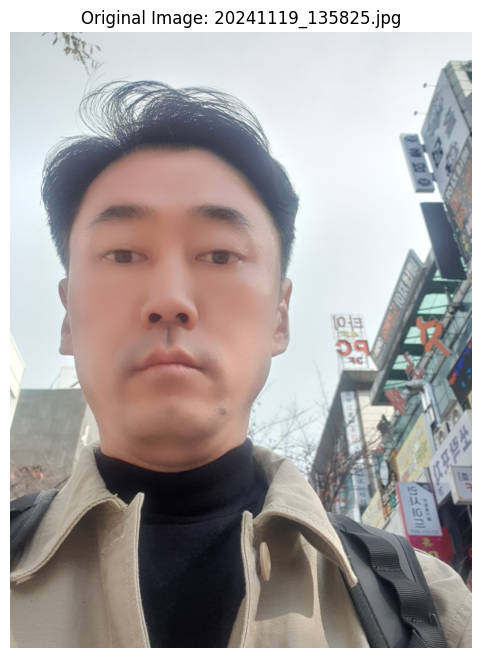

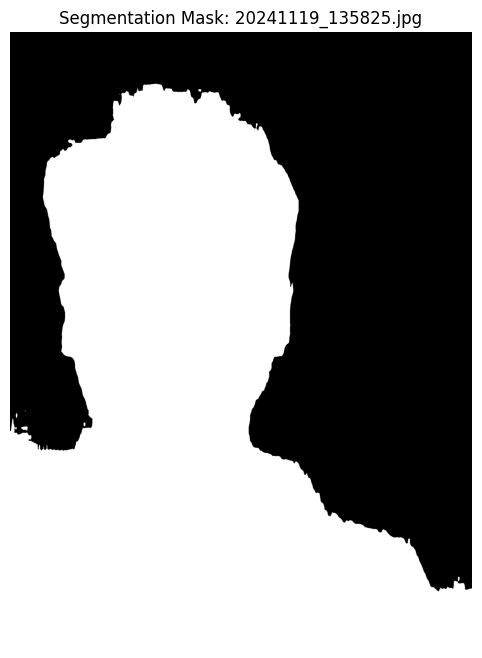

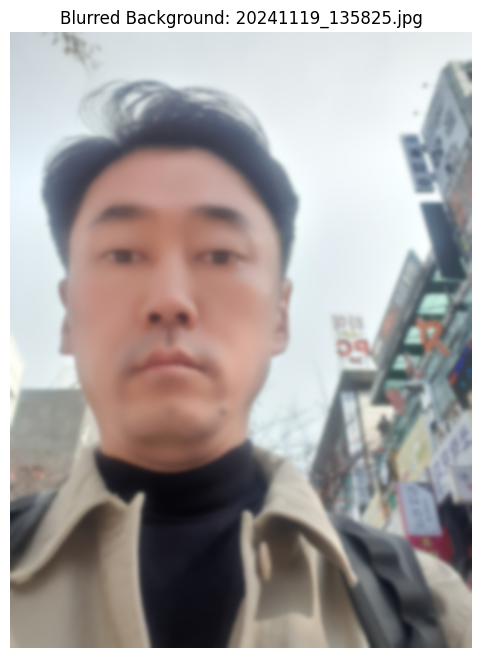

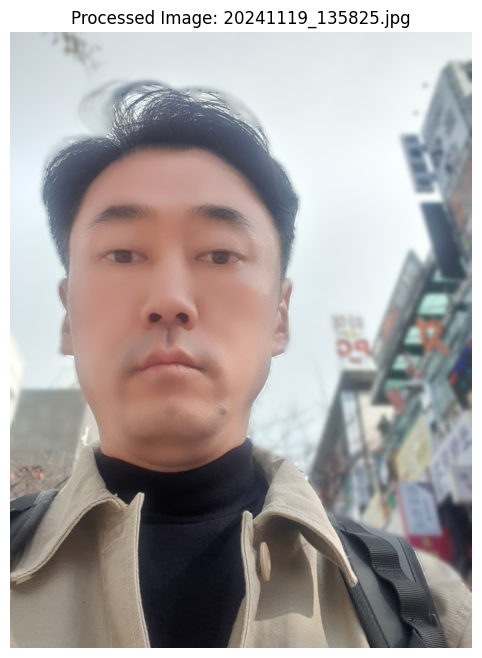

In [23]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

# 이미지 폴더 경로 설정
image_folder = '/content/sample_data/exploration_03/image'
output_folder = '/content/sample_data/exploration_03/output'

# 출력 폴더가 없다면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# MediaPipe Selfie Segmentation 초기화
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# 이미지 처리
for image_name in os.listdir(image_folder):
    # 이미지 경로 설정
    img_path = os.path.join(image_folder, image_name)

    # 이미지 읽기
    image = cv2.imread(img_path)

    # 이미지가 읽히지 않으면 건너뛰기
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # 셀피 세그멘테이션 처리 (이미지 -> RGB 변환 후 처리)
    results = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 세그멘테이션 마스크 추출 (배경, 인물)
    mask = results.segmentation_mask > 0.5  # 마스크 값이 0.5보다 큰 영역만 사용
    mask = mask.astype(np.uint8) * 255  # 0과 255로 변환 (흑백 마스크)

    # 배경 흐림 처리 (GaussianBlur)
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 마스크와 배경 흐림을 결합하여 최종 이미지 생성
    mask_3ch = cv2.merge([mask, mask, mask])  # 마스크를 3채널로 확장
    output_image = np.where(mask_3ch == 255, image, blurred_bg)  # 마스크가 255인 영역은 원본 이미지, 나머지 배경 흐림

    # 처리된 이미지 저장
    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    cv2.imwrite(output_path, output_image)
    print(f"{image_name} 처리 완료. 저장: {output_path}")

    # 중간 처리과정 이미지 출력
    # 1. 원본 이미지
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Original Image: {image_name}")
    plt.show()

    # 2. 세그멘테이션 마스크
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title(f"Segmentation Mask: {image_name}")
    plt.show()

    # 3. 흐림 처리된 배경
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(blurred_bg, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Blurred Background: {image_name}")
    plt.show()

    # 4. 최종 처리된 이미지
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # BGR -> RGB 변환
    plt.axis('off')
    plt.title(f"Processed Image: {image_name}")
    plt.show()
